<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Nome da Doença                      99 non-null     object 
 1   Categoria                           99 non-null     object 
 2   Região mais Afetada                 99 non-null     object 
 3   Incidência Anual (por 100k hab)     99 non-null     int64  
 4   Faixa Etária Afetada                99 non-null     object 
 5   Mortalidade (%)                     99 non-null     float64
 6   Número de Casos                     99 non-null     int64  
 7   Tipo de Tratamento                  99 non-null     object 
 8   Custo Médio do Tratamento (R$)      99 non-null     int64  
 9   Duração Média do Tratamento (dias)  99 non-null     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 7.9+ KB
Região mais Afetada
Sul             25
Nordeste        

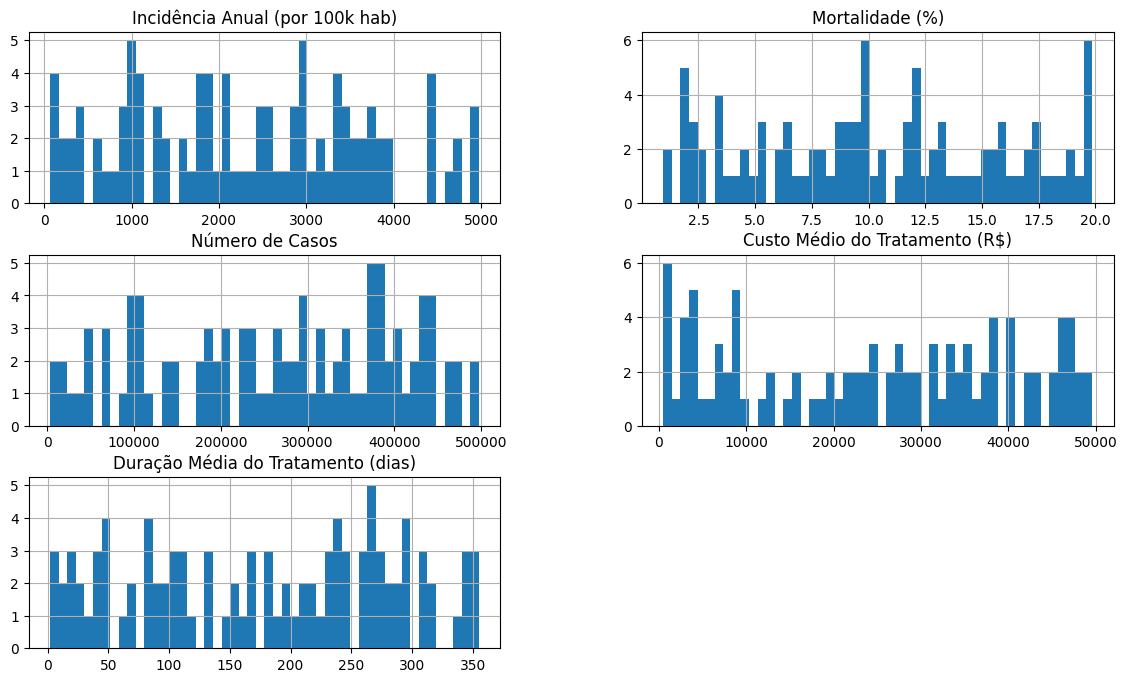

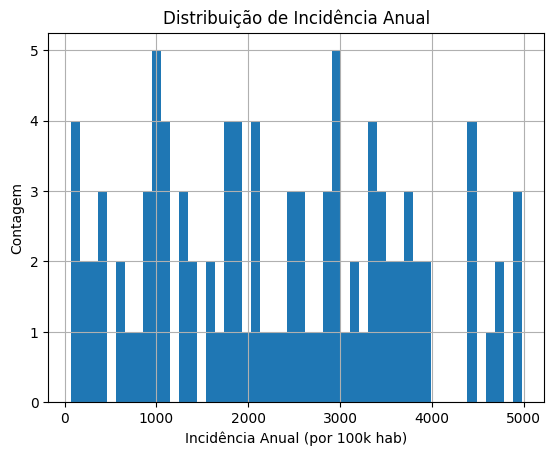

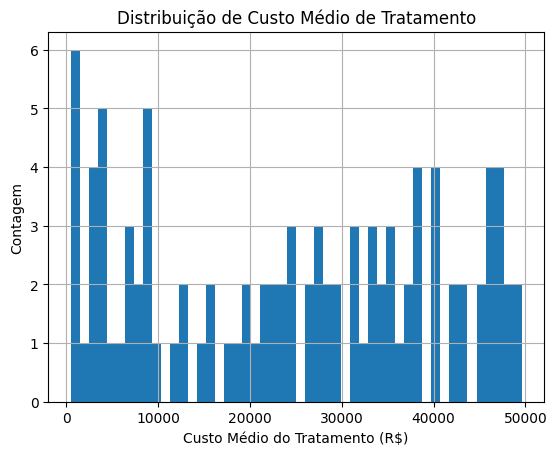

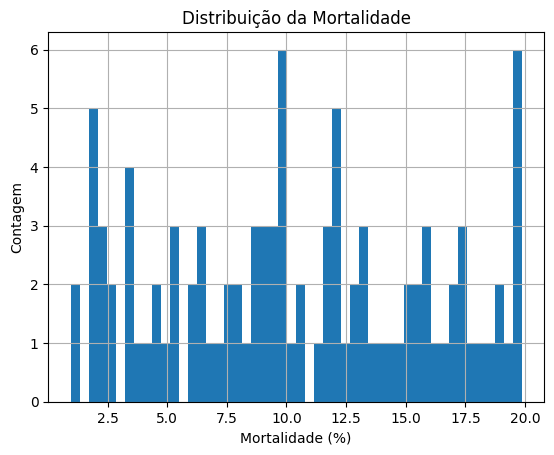

<Axes: xlabel='Mortalidade (%)', ylabel='Density'>

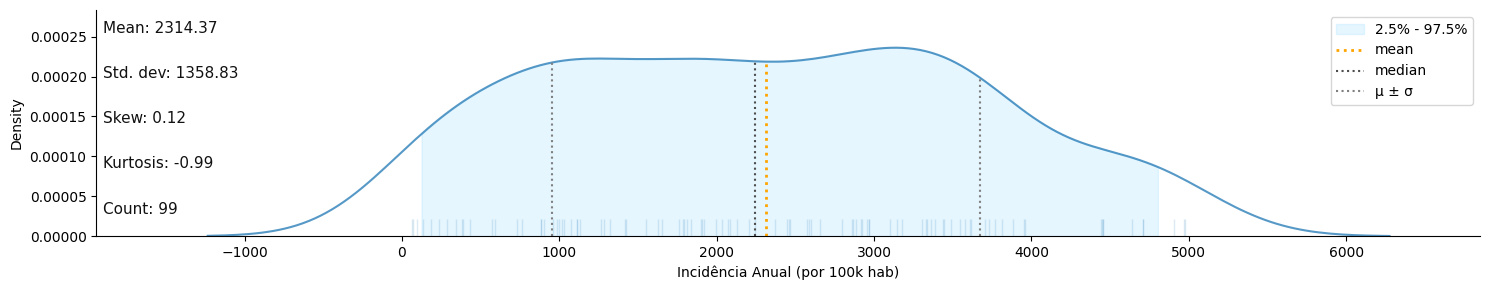

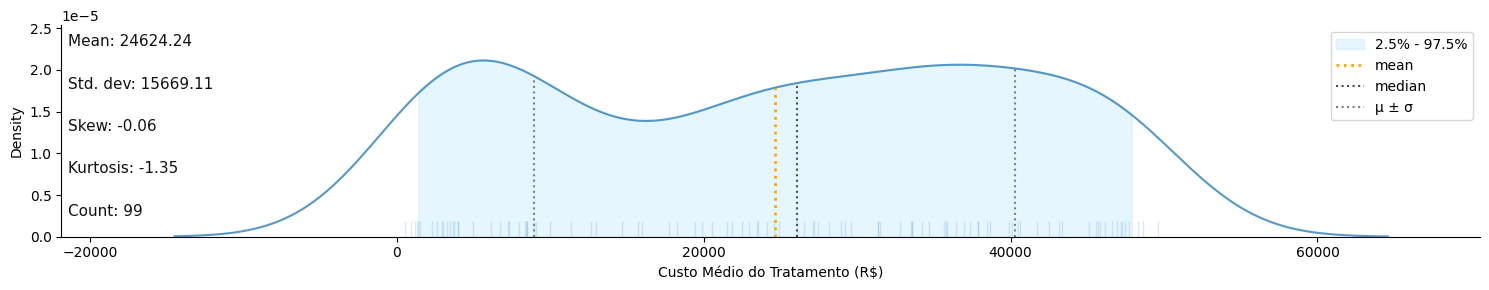

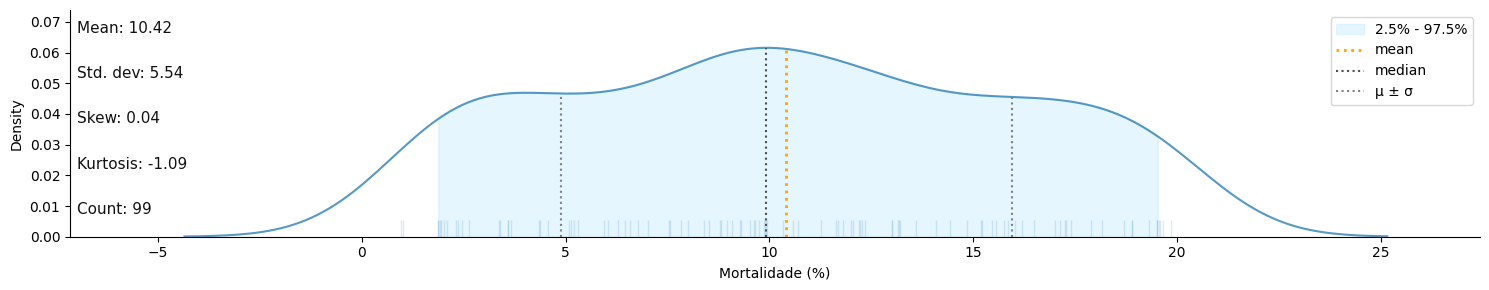

In [2]:
# Importando bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import klib

# Carregando o CSV
df = pd.read_csv('large_doencas_brasil.csv')

# Verificando as informações gerais do dataframe
df.info()

# Estatísticas descritivas do dataframe
df_describe = df.describe()

# Verificando a variável categórica - por exemplo, Região ou Tipo de Doença
categorical_column = 'Região mais Afetada'  # Ajustar o nome da coluna conforme o CSV
grupos = df[categorical_column].value_counts()
print(grupos)

# Visualizando histogramas de todas as variáveis do dataframe
df.hist(bins=50, figsize=(14,8))
plt.show()

# Visualizando histogramas de variáveis específicas
df['Incidência Anual (por 100k hab)'].hist(bins=50)
plt.xlabel('Incidência Anual (por 100k hab)')
plt.ylabel('Contagem')
plt.title('Distribuição de Incidência Anual')
plt.show()

df['Custo Médio do Tratamento (R$)'].hist(bins=50)
plt.xlabel('Custo Médio do Tratamento (R$)')
plt.ylabel('Contagem')
plt.title('Distribuição de Custo Médio de Tratamento')
plt.show()

df['Mortalidade (%)'].hist(bins=50)
plt.xlabel('Mortalidade (%)')
plt.ylabel('Contagem')
plt.title('Distribuição da Mortalidade')
plt.show()

# Usando klib para visualizar distribuições mais detalhadas
klib.dist_plot(df['Incidência Anual (por 100k hab)'])
klib.dist_plot(df['Custo Médio do Tratamento (R$)'])
klib.dist_plot(df['Mortalidade (%)'])